In [9]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from glob import glob
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import dask

%matplotlib inline

In [2]:
bath = xr.open_dataset('../data/subset_largeETOPO1_Ice_g_gmt4.grd')

In [4]:
SMAP=xr.open_dataset('../data/RSS_smap_SSS_L3_monthly_2015_2022_FNL_v04.0.nc')

## Define plotting functions

In [7]:
def plot_map(ax):

    ax.set_extent([150, 155, -36, -28], crs=ccrs.PlateCarree())
    cs=bath.z.plot.contour(levels=[-1000],colors='k',transform=ccrs.PlateCarree())
    cs.clabel(fontsize=12, inline=1)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MaxNLocator(6)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #add coast
    ax.add_feature(cfeature.GSHHSFeature('i', edgecolor='black', facecolor='lightgrey'))

In [14]:
def plot_map_alt(ax):

    ax.set_extent([150, 155, -36, -28], crs=ccrs.PlateCarree())
    cs=bath.z.plot.contour(levels=[-1000],colors='k',transform=ccrs.PlateCarree())
    cs.clabel(fontsize=12, inline=1)
    # Gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.2, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    gl.xlocator = mticker.MaxNLocator(6)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #add coast
    ax.add_feature(cfeature.GSHHSFeature('i', edgecolor='black', facecolor='lightgrey'))

## Separate out box at Hawkesbury shelf latitudes 

In [12]:
SMAP_ph = SMAP.sel(lat=slice(-34,-32.5))

# Plot

/Users/neilmalan/miniconda3/envs/Ncomms2023/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


Text(0.0, 1.0, 'd)')

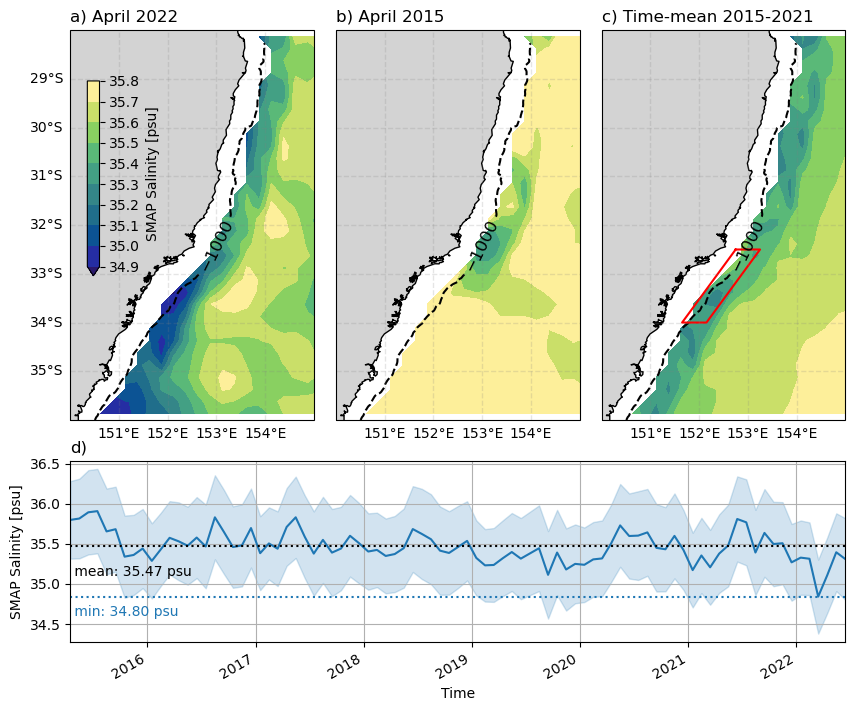

In [15]:
mosaic = """
    AABBCC
    AABBCC
    DDDDDD
    """

fig = plt.figure(figsize=(10,8))
levs = 10
vmin = 34.9
vmax = 35.8


ax = fig.subplot_mosaic(mosaic)
# trick to add cartopy axes (https://github.com/matplotlib/matplotlib/issues/20392)
ss = ax['A'].get_subplotspec()
ax['A'].remove()
ax['A'] = fig.add_subplot(ss, projection=ccrs.PlateCarree())
plot_map(ax['A'])
im = SMAP.sss_smap.sel(time='2022-04').squeeze().plot.contourf(cmap=cmo.haline, 
                                                               levels=levs, 
                                                               add_colorbar=False,
                                                               vmin=vmin,vmax=vmax)

plt.title('')
ax['A'].set_title('a) April 2022',loc='left')
cax = inset_axes(ax['A'],
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.37, 1, 1),
                bbox_transform=ax['A'].transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('SMAP Salinity [psu]')

ss = ax['B'].get_subplotspec()
ax['B'].remove()
ax['B'] = fig.add_subplot(ss, projection=ccrs.PlateCarree())
plot_map_alt(ax['B'])
im = SMAP.sss_smap.sel(time='2015-04').squeeze().plot.contourf(cmap=cmo.haline, 
                                                               levels=levs, 
                                                               add_colorbar=False,
                                                               vmin=vmin,vmax=vmax)
plt.title('')
ax['B'].set_title('b) April 2015',loc='left')

ss = ax['C'].get_subplotspec()
ax['C'].remove()
ax['C'] = fig.add_subplot(ss, projection=ccrs.PlateCarree())
plot_map_alt(ax['C'])
mean_salt = SMAP.sss_smap.sel(time=slice(SMAP.time[0],'2021-12-31')).mean('time')
im = mean_salt.plot.contourf(cmap=cmo.haline, 
                        levels=levs, 
                        add_colorbar=False,
                        vmin=vmin,vmax=vmax)

boxlons=[152.75,153.25,152.15,151.65,152.75]
boxlats=[-32.5,-32.5,-34,-34,-32.5]
plt.plot(boxlons,boxlats,color='red')
plt.title('c) Time-mean 2015-2021',loc='left')

#plt.subplot(2,1,2)
#plot timeseries from box
y = SMAP_ph.sss_smap.where(SMAP_ph.h>-4000).mean(['lat','lon'])
y_err = SMAP_ph.sss_smap_uncertainty.where(SMAP_ph.h>-4000).mean(['lat','lon'])
y.plot(ax=ax['D'])
#shade by uncertainty
ax['D'].fill_between(SMAP_ph.time, y - y_err, y + y_err,
                 color='tab:blue', alpha=0.2)
#put mean an dmin as horizontal lines
y_mean = y.mean('time')
y_min = y.min('time')
ax['D'].axhline(y=y_mean.values, color='black', linestyle=':',label='mean')
ax['D'].axhline(y=y_min.values, color='tab:blue', linestyle=':',label='minimum')
ax['D'].text(SMAP_ph.time[0].values,35.1,' mean: 35.47 psu')
ax['D'].text(SMAP_ph.time[0].values,34.6,' min: 34.80 psu',color='tab:blue')
#ax['D'].legend()

ax['D'].set_xlim(SMAP_ph.time[0],SMAP_ph.time[-1])
ax['D'].grid()
ax['D'].set_ylabel('SMAP Salinity [psu]')
ax['D'].set_xlabel('Time')
ax['D'].set_title('d)',loc='left')